In [16]:
from matplotlib import pyplot as plt

In [17]:
import pandas as pd
import numpy as np
import copy
import json
import geopandas as gpd
from shapely.geometry import box

In [18]:
from arcgis.gis import GIS

In [19]:
from arcgis import geocode

In [20]:
from arcgis.geoenrichment import enrich, Country

In [21]:
from arcgis.geometry import BaseGeometry, Geometry
@classmethod
def from_shapely(cls, shapely_geometry):
    return cls(shapely_geometry.__geo_interface__)

BaseGeometry.from_shapely = from_shapely

In [22]:
# init GIS connection
with open("agol_account_info.txt", "r") as f:
    url, username, password = f.read().splitlines()

In [23]:
gis = GIS(url, username=username, password=password)

In [24]:
# init llm connection
with open("openai_api_key", "r") as f:
    MY_API_KEY = f.readline()

In [25]:
import openai
from keybert.llm import OpenAI
from keybert import KeyLLM

# Create your LLM
client = openai.OpenAI(api_key=MY_API_KEY)
llm = OpenAI(client)

# Load it in KeyLLM
kw_model = KeyLLM(llm)

In [26]:
import psycopg2

In [27]:
# init db connection
with open("awesome_db_key", "r") as f:
    database, host, user, password, port = f.read().splitlines()

In [28]:
conn = psycopg2.connect(database=database,
                        host=host,
                        user=user,
                        password=password,
                        port=port)

In [29]:
cursor = conn.cursor()

In [30]:
# this is small enough to fetch all, bad practice
cursor.execute("""
SELECT id, city, community, zipcodes FROM public.community_neighborhoods
ORDER BY id ASC 
""")
db_out = cursor.fetchall()


In [31]:
community_neighborhoods_df = pd.DataFrame(db_out, columns =["id", "city", "community", "zipcodes"])

In [32]:
community_neighborhoods_df

,id,city,community,zipcodes
0,1,San Diego,Adams North,"[92108, 92116]"
1,2,San Diego,Allied Gardens,[92120]
2,3,San Diego,Alta Vista,"[91950, 92114]"
3,4,San Diego,Amphitheater and Water Park,[92154]
4,5,San Diego,Azalea-Hollywood Park,None
...,...,...,...,...
224,443,San Marcos,Rancho La Costa,"[92009, 92011, 92078]"
225,451,Imperial Beach,Egger Highlands,"[91911, 91932, 92154]"
226,453,Imperial Beach,Tijuana River Valley,"[92154, 92173]"
227,458,La Presa,Jomacha Lomita,"[91945, 91977, 92114]"


In [115]:
stop_words = ['region', 'location', 'geographical location', 'street', 'streets', 'landmarks', 'area', 'part']
directional_predictates = ['north', 'south', 'west', 'east']
arcgis_community_boundaries_lyr = gis.content.get("23a806fb906e428cb75d123cf2ab580c").layers[0]
community_boundaries_sdf = pd.DataFrame.spatial.from_layer(arcgis_community_boundaries_lyr)
fset = arcgis_community_boundaries_lyr.query()
gjson_string = fset.to_geojson
community_boundaries_gdf = gpd.read_file(gjson_string, driver='GeoJSON').set_crs(2230, allow_override=True)
sd_roads_gdf = gpd.read_file('sd_roads.json', driver='GeoJSON').set_crs(2230, allow_override=True)



In [ ]:
def get_extent(geom_id, geom_txt):
    if geom_id == 0:
        return get_community(geom_txt)
    elif geom_id == 1:
        return get_poi(geom_txt)
    elif geom_id == 2:
        return get_road(geom_txt)
    else:
        raise Exception("Invalid geom_id")


def get_community(geom_txt):
    
    keywords = kw_model.extract_keywords(geom_txt)[0]
    dw_out = []
    community_out = []
    for kw in copy.deepcopy(keywords):
        for dw in directional_predictates:
            if dw in kw.lower():
                dw_out.append(dw)
                keywords.remove(kw)


    for kw in keywords:    
        kw_community = community_neighborhoods_df[
            community_neighborhoods_df.apply(
                lambda row: kw.lower() in row['community'].lower(), 
                axis = 1)
        ]
        if len(kw_community):
            community_out.append(kw)

    geocode_out = []
    for kw in community_out:
        geocode_out.append(geocode(address = kw, max_locations = 10))
        
        
    for g_out in geocode_out[0]:
        p = g_out['location']
        p = gpd.GeoSeries(shapely.Point(p['x'],  p['y'])).set_crs(4326).to_crs(2230)
        temp_gdf = community_boundaries_gdf[community_boundaries_gdf.geometry.contains(p[0])]
        if len(temp_gdf):
            # the geocode out are ranked in confidence score
            # break the first outcome is found
            break
    
    community_shape = temp_gdf.geometry.iloc[0]
    x,y = community_shape.centroid.x, community_shape.centroid.y
    minx, miny, maxx, maxy = community_shape.bounds
    
    
    l1 = shapely.LineString([(x, miny), (x, maxy)])
    l2 = shapely.LineString([(minx, y), (maxx, y)])
    
    out_poly = []
    for dw in dw_out:
        if dw in ['north', 'south']:
            out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
        else:
            out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
        out_poly.append(out_dict[dw])
        
    return out_poly[0]
    

def get_poi(geom_txt):
    
    keywords = kw_model.extract_keywords(e)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = geocode(address = " ".join(keywords) + ", San Diego", max_locations = 1)[0]
    return gpd.GeoSeries(shapely.Point(geocode_out['location']['x'],  geocode_out['location']['y'])).set_crs(4326).to_crs(2230).buffer(100)[0]


def get_road(geom_txt):
    keywords = kw_model.extract_keywords(e)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = []
    # specify SD to be disambiguous for geocode
    for kw in keywords:
        geocode_out.append(geocode(address = kw + ", San Diego", max_locations = 1)[0]['location'])
    
    
    rd = []
    for g_out in geocode_out:
        p = gpd.GeoSeries(shapely.Point(g_out['x'],  g_out['y'])).set_crs(4326).to_crs(2230).buffer(100)
        rd.append(sd_roads_gdf[sd_roads_gdf.geometry.crosses(p[0])])
    
    out_road = []
    for r in rd:
        rd_name = r.RD20FULL.iloc[0]
        road_segments = sd_roads_gdf[sd_roads_gdf['RD20FULL'] == rd_name]['geometry'].tolist()
        temp_road = road_segments[0]
        for r in road_segments[1:]:
            temp_road = temp_road.union(r)
        out_road.append(temp_road)
        
    simple_rd = []
    for rd in out_road:
        minx, miny, maxx, maxy = rd.bounds
        if (maxy - miny) > (maxx - minx):
            x = rd.centroid.x
            simple_rd.append(shapely.LineString([(x, miny), (x, maxy)]))
        else:

            y = rd.centroid.y
            simple_rd.append(shapely.LineString([(minx, y), (maxx, y)]))
    
    
    rd_bound = []
    road = None
    for rd1 in simple_rd:
        count = 0
        for rd2 in simple_rd:
            if rd1.crosses(rd2): count += 1 
        if count == 2:
            for i, rd2 in enumerate(simple_rd):
                pt = rd1.intersection(rd2)
                if isinstance(pt, shapely.Point):
                    rd_bound.append(pt)
                else:
                    road = out_road[i]
            break
            
    idxmax = np.argmax(np.abs(np.array(rd_bound[0].bounds) - rd_bound[1].bounds))
    maxpt1, maxpt2 = rd_bound[0].xy[idxmax][0], rd_bound[1].xy[idxmax][0]
    minx, miny, maxx, maxy = road.bounds
    minx, maxx = min(maxpt1, maxpt2), max(maxpt1, maxpt2)
    
    out_road = box(minx, miny, maxx, maxy).intersection(road)
    
    return out_road.buffer(100)

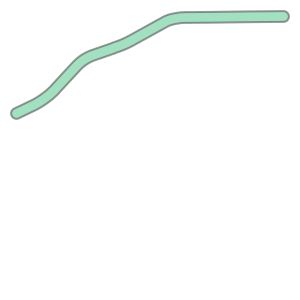

In [116]:
get_extent(2, "on El Cajon Blvd between 63rd and 70th streets")

## 0 community

In [35]:
e1, e2 = "south Del Mar", "northern part of Carmel Valley"

In [49]:
# Extract keywords
keywords = kw_model.extract_keywords(e2)[0]

In [50]:
keywords

['Northern', 'Carmel Valley', 'Location', 'Geographic region']

In [51]:
directional_predictates = ['north', 'south', 'west', 'east']

In [52]:
dw_out = []
community_out = []
for kw in copy.deepcopy(keywords):
    for dw in directional_predictates:
        if dw in kw.lower():
            dw_out.append(dw)
            keywords.remove(kw)


for kw in keywords:    
    kw_community = community_neighborhoods_df[
        community_neighborhoods_df.apply(
            lambda row: kw.lower() in row['community'].lower(), 
            axis = 1)
    ]
    if len(kw_community):
        community_out.append(kw)


In [53]:
dw_out

['north']

In [55]:
community_out

['Carmel Valley']

In [56]:
geocode_out = []
for kw in community_out:
    geocode_out.append(geocode(address = kw, max_locations = 10))

In [57]:
geocode_out[0]

[{'address': 'Carmel Valley, California',
  'location': {'x': -121.731518, 'y': 36.479342},
  'score': 100,
  'attributes': {'Loc_name': 'World',
   'Status': 'T',
   'Score': 100,
   'Match_addr': 'Carmel Valley, California',
   'LongLabel': 'Carmel Valley, CA, USA',
   'ShortLabel': 'Carmel Valley',
   'Addr_type': 'Locality',
   'Type': 'City',
   'PlaceName': 'Carmel Valley',
   'Place_addr': 'Carmel Valley, California',
   'Phone': '',
   'URL': '',
   'Rank': 11.73,
   'AddBldg': '',
   'AddNum': '',
   'AddNumFrom': '',
   'AddNumTo': '',
   'AddRange': '',
   'Side': '',
   'StPreDir': '',
   'StPreType': '',
   'StName': '',
   'StType': '',
   'StDir': '',
   'BldgType': '',
   'BldgName': '',
   'LevelType': '',
   'LevelName': '',
   'UnitType': '',
   'UnitName': '',
   'SubAddr': '',
   'StAddr': '',
   'Block': '',
   'Sector': '',
   'Nbrhd': '',
   'District': '',
   'City': 'Carmel Valley',
   'MetroArea': '',
   'Subregion': 'Monterey County',
   'Region': 'Californi

In [58]:
import shapely
from shapely.ops import split

In [59]:
from arcgis.geometry import Point

In [60]:
arcgis_community_boundaries_lyr = gis.content.get("23a806fb906e428cb75d123cf2ab580c").layers[0]

In [61]:
community_boundaries_sdf = pd.DataFrame.spatial.from_layer(arcgis_community_boundaries_lyr)

In [62]:
fset = arcgis_community_boundaries_lyr.query()

In [63]:
gjson_string = fset.to_geojson

In [64]:
community_boundaries_gdf = gpd.read_file(gjson_string, driver='GeoJSON').set_crs(2230, allow_override=True)

<AxesSubplot: >

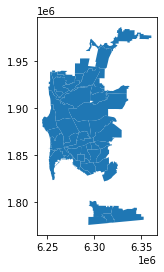

In [65]:
community_boundaries_gdf.plot()

In [66]:
for g_out in geocode_out[0]:
    p = g_out['location']
    p = gpd.GeoSeries(shapely.Point(p['x'],  p['y'])).set_crs(4326).to_crs(2230)
    temp_gdf = community_boundaries_gdf[community_boundaries_gdf.geometry.contains(p[0])]
    if len(temp_gdf):
        # the geocode out are ranked in confidence score
        # break the first outcome is found
        break

In [67]:
community_shape = temp_gdf.geometry.iloc[0]
x,y = community_shape.centroid.x, community_shape.centroid.y
minx, miny, maxx, maxy = community_shape.bounds

In [68]:
l1 = shapely.LineString([(x, miny), (x, maxy)])
l2 = shapely.LineString([(minx, y), (maxx, y)])

In [69]:
out_poly = []
for dw in dw_out:
    if dw in ['north', 'south']:
        out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
    else:
        out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
    out_poly.append(out_dict[dw])

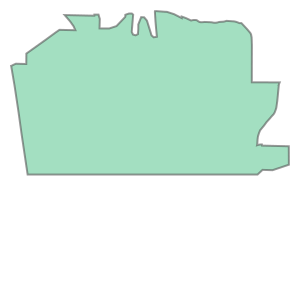

In [70]:
out_poly[0]

In [71]:
arcgis_poly = Geometry.from_shapely(out_poly[0])

In [72]:
arcgis_poly["spatialReference"] = {"wkid" : 2230}

In [100]:
usa = Country('usa')

In [101]:
usa.enrich_variables.data_collection.unique()

array(['1yearincrements', '5yearincrements', 'Age', 'agebyracebysex',
       'agebyracebysex2010', 'agebyracebysex2020', 'AgeDependency',
       'AtRisk', 'AutomobilesAutomotiveProducts', 'BabyProductsToysGames',
       'basicFactsForMobileApps', 'businesses',
       'CivicActivitiesPoliticalAffiliation', 'classofworker', 'clothing',
       'ClothingShoesAccessories', 'commute', 'crime',
       'DaytimePopulation', 'disability', 'disposableincome', 'DniRates',
       'education', 'educationalattainment', 'ElectronicsInternet',
       'employees', 'EmploymentUnemployment', 'entertainment',
       'financial', 'FinancialInsurance', 'food', 'foodstampsSNAP',
       'gender', 'Generations', 'GroceryAlcoholicBeverages',
       'groupquarters', 'Health', 'healthinsurancecoverage',
       'HealthPersonalCare', 'HealthPersonalCareCEX', 'heatingfuel',
       'hispanicorigin', 'HistoricalHouseholds', 'HistoricalHousing',
       'HistoricalPopulation', 'HomeImprovementGardenLawn', 'homevalue',
  

In [ ]:
usa.enrich(stu)

In [97]:
enriched = enrich([arcgis_poly], ['TOTALPOP_CY'])

Exception: One or more of the data collections you requested is not available. The only data
collection available globally is "KeyGlobalFacts". For working with data specific to a country, you
can discover available data collections using Country.enrich_variables.data_collection.unique(). Data collections are case sensitive.

In [121]:
enriched

,source_country,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,has_data,male0,male5,male10,male15,male20,...,fem45,fem50,fem55,fem60,fem65,fem70,fem75,fem80,fem85,SHAPE
0,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,587.0,683.0,907.0,913.0,770.0,...,1030.0,1079.0,974.0,814.0,568.0,415.0,277.0,151.0,167.0,"{""rings"": [[[6257138.980673283, 1924755.133257..."


## 1 POI

In [44]:
e = "around the 24-Hour Fitness on Balboa Ave."

In [45]:
# Extract keywords
keywords = kw_model.extract_keywords(e)[0]
for kw in keywords.copy():
    if kw.lower() in stop_words:
        keywords.remove(kw)

In [46]:
keywords

['24-Hour Fitness', 'Balboa Ave']

In [47]:
geocode_out = geocode(address = " ".join(keywords) + ", San Diego", max_locations = 1)[0]

In [48]:
geocode_out

{'address': '24 Hour Fitness',
 'location': {'x': -117.158353, 'y': 32.820471},
 'score': 100,
 'attributes': {'Loc_name': 'World',
  'Status': 'M',
  'Score': 100,
  'Match_addr': '24 Hour Fitness',
  'LongLabel': '24 Hour Fitness, 7715 Balboa Ave, San Diego, CA, 92111, USA',
  'ShortLabel': '24 Hour Fitness',
  'Addr_type': 'POI',
  'Type': 'Fitness Center',
  'PlaceName': '24 Hour Fitness',
  'Place_addr': '7715 Balboa Ave, San Diego, California, 92111',
  'Phone': '(858) 292-7079',
  'URL': '',
  'Rank': 19,
  'AddBldg': '',
  'AddNum': '7715',
  'AddNumFrom': '',
  'AddNumTo': '',
  'AddRange': '',
  'Side': '',
  'StPreDir': '',
  'StPreType': '',
  'StName': 'Balboa',
  'StType': 'Ave',
  'StDir': '',
  'BldgType': '',
  'BldgName': '',
  'LevelType': '',
  'LevelName': '',
  'UnitType': '',
  'UnitName': '',
  'SubAddr': '',
  'StAddr': '7715 Balboa Ave',
  'Block': '',
  'Sector': '',
  'Nbrhd': '',
  'District': '',
  'City': 'San Diego',
  'MetroArea': '',
  'Subregion': 'Sa

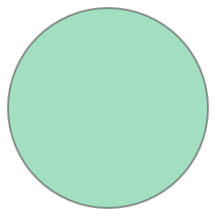

In [49]:
gpd.GeoSeries(shapely.Point(geocode_out['location']['x'],  geocode_out['location']['y'])).set_crs(4326).to_crs(2230).buffer(100)[0]

## 2 POI (Polygon)

In [50]:
e1, e2 = "near UTC", "near Balboa Park"

In [51]:
# need data for landmark polygons

## 3 street segments

In [73]:
e = "on El Cajon Blvd between 63rd and 70th streets"

In [74]:
# Extract keywords
keywords = kw_model.extract_keywords(e)[0]

In [75]:
for kw in keywords.copy():
    if kw.lower() in stop_words:
        keywords.remove(kw)

In [76]:
keywords

['El Cajon Blvd', '63rd street', '70th street']

In [77]:
geocode_out = []
# specify SD to be disambiguous for geocode
for kw in keywords:
    geocode_out.append(geocode(address = kw + ", San Diego", max_locations = 1)[0]['location'])

In [78]:
geocode_out

[{'x': -117.065754570721, 'y': 32.762214735752},
 {'x': -117.063339537401, 'y': 32.767107358976},
 {'x': -117.046364782356, 'y': 32.773663010316}]

In [48]:
# this takes long
sd_roads_gdf = gpd.read_file('sd_roads.json', driver='GeoJSON').set_crs(2230, allow_override=True)

In [79]:
sd_roads_gdf

,OBJECTID,FNODE,TNODE,LENGTH,ROADSEGID,POSTID,POSTDATE,ROADID,RIGHTWAY,ADDSEGDT,...,RD20NAME,RD20SFX,RD20FULL,RD30PRED,RD30NAME,RD30SFX,RD30POSTD,RD30FULL,Shape__Length,geometry
0,1,21662,21647,89.086826,1755,rodonnell,1381505945000,2185,56.0,3.233952e+11,...,AVNDA DE LOUISA,NaN,AVNDA DE LOUISA,NaN,AVENIDA DE LOUISA,NaN,NaN,AVENIDA DE LOUISA,89.086677,"MULTILINESTRING ((6233669.000 2009343.000, 623..."
1,2,21647,21702,237.695636,1756,rodonnell,1381505605000,2185,56.0,4.864320e+11,...,AVNDA DE LOUISA,NaN,AVNDA DE LOUISA,NaN,AVENIDA DE LOUISA,NaN,NaN,AVENIDA DE LOUISA,237.695778,"MULTILINESTRING ((6233750.000 2009377.000, 623..."
2,3,103915,103894,173.303203,1767,fjessie,1557323375000,2189,80.0,3.233952e+11,...,06TH,ST,E 06TH ST,E,06TH,ST,NaN,E 06TH ST,173.303168,"MULTILINESTRING ((6299195.000 1827850.000, 629..."
3,4,103980,103955,163.174753,1774,fjessie,1412935146000,2189,0.0,3.233952e+11,...,06TH,ST,E 06TH ST,E,06TH,ST,NaN,E 06TH ST,163.174738,"MULTILINESTRING ((6298732.000 1827699.000, 629..."
4,5,103747,103737,164.174352,1785,fjessie,1557323354000,2189,0.0,3.233952e+11,...,06TH,ST,E 06TH ST,E,06TH,ST,NaN,E 06TH ST,164.174327,"MULTILINESTRING ((6300460.999 1828261.001, 630..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163878,163879,190796,190791,133.090991,231373,KPalm,1647441044000,130571,0.0,1.647441e+12,...,STAR FRUIT,ST,STAR FRUIT ST,,STAR FRUIT,ST,,STAR FRUIT ST,133.070796,"MULTILINESTRING ((6340183.646 1844453.338, 634..."
163879,163880,190805,190791,138.398057,231387,KPalm,1647443872000,130564,0.0,1.647444e+12,...,BABACO,ST,BABACO ST,,BABACO,ST,,BABACO ST,138.398023,"MULTILINESTRING ((6340355.896 1844658.284, 634..."
163880,163881,190799,190807,121.203279,231389,KPalm,1647444126000,130566,0.0,1.647444e+12,...,JUJUBE,ST,JUJUBE ST,,JUJUBE,ST,,JUJUBE ST,121.203351,"MULTILINESTRING ((6340132.458 1844803.076, 634..."
163881,163882,153703,190814,128.234997,231414,drewdowling,1703119003000,27003,0.0,1.648484e+12,...,PRIVATE,RD,PRIVATE RD,NaN,PRIVATE,RD,NaN,PRIVATE RD,128.234047,"MULTILINESTRING ((6160319.256 2110731.375, 616..."


In [80]:
rd = []
for g_out in geocode_out:
    p = gpd.GeoSeries(shapely.Point(g_out['x'],  g_out['y'])).set_crs(4326).to_crs(2230).buffer(100)
    rd.append(sd_roads_gdf[sd_roads_gdf.geometry.crosses(p[0])])

In [81]:
out_road = []
for r in rd:
    rd_name = r.RD20FULL.iloc[0]
    road_segments = sd_roads_gdf[sd_roads_gdf['RD20FULL'] == rd_name]['geometry'].tolist()
    temp_road = road_segments[0]
    for r in road_segments[1:]:
        temp_road = temp_road.union(r)
    out_road.append(temp_road)

In [82]:
simple_rd = []
for rd in out_road:
    minx, miny, maxx, maxy = rd.bounds
    if (maxy - miny) > (maxx - minx):
        x = rd.centroid.x
        simple_rd.append(shapely.LineString([(x, miny), (x, maxy)]))
    else:

        y = rd.centroid.y
        simple_rd.append(shapely.LineString([(minx, y), (maxx, y)]))

In [83]:
rd_bound = []
road = None
for rd1 in simple_rd:
    count = 0
    for rd2 in simple_rd:
        if rd1.crosses(rd2): count += 1 
    if count == 2:
        for i, rd2 in enumerate(simple_rd):
            pt = rd1.intersection(rd2)
            if isinstance(pt, shapely.Point):
                rd_bound.append(pt)
            else:
                road = out_road[i]
        break

In [84]:
import numpy as np

In [85]:
idxmax = np.argmax(np.abs(np.array(rd_bound[0].bounds) - rd_bound[1].bounds))

In [86]:
maxpt1, maxpt2 = rd_bound[0].xy[idxmax][0], rd_bound[1].xy[idxmax][0]

In [87]:
minx, miny, maxx, maxy = road.bounds

In [88]:
minx, maxx = min(maxpt1, maxpt2), max(maxpt1, maxpt2)

In [89]:
from shapely.geometry import box
out_road = box(minx, miny, maxx, maxy).intersection(road)

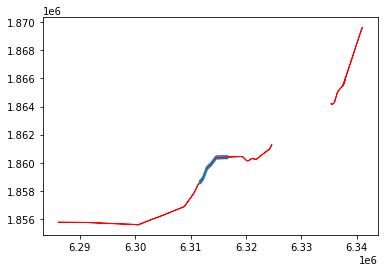

In [90]:
fig, axs = plt.subplots()

for geom in road.buffer(5).geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=1, color='red')

plt.plot(*out_road.buffer(100).exterior.xy)


In [106]:
sd_roads_gdf.to_file(r'sd_roads/sd_roads.shp')

<ipython-input-106-3d5ff846fbf4>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sd_roads_gdf.to_file(r'sd_roads/sd_roads.shp')


In [ ]:
def get_geodata(geom_id, geom_txt, resolution, var_lst):
    

In [91]:
# this takes long
sd_bgs_gdf = gpd.read_file('sd_bgs_enriched.json', driver='GeoJSON')

In [95]:
sd_bgs_gdf = sd_bgs_gdf.to_crs(2230)